I'm creating a Neural Network form scratch (without Tensorflow/Keras/Pytorch) to understand better the math behind it. <br><br>
I want to keep everything as simple as possible.
The architeture:
* 1 input layer made of 784 neurons
* 1 hidden layer made of 10 neurons
* 1 output layer made of 10 neurons

The principal component:
* Dataset: MNIST dataset
* Cost function: $\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} | y_i - \hat{y}_i |$
* Optimization procedure: gradient descent
* Model: ANN

Other components:
* Activation function: ReLu and SoftMax


(A quick review) A Deep learning approach is divided in 4 main phases:
* Inizialization of the paramters: random inizializations of the Bias and Weigths
* Forward propagation: takes the input data, it multiplies it to the corrispondent weights and add the bias.
* Backward propagation: Calculate the Cost (how much i've been wrong) and how much each Weight and Bias is in charge of that error.
* Parameters update: Update the Weights and Bias according to the optimization procedure

INIZIALIZATION

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#Split the data into train and test.
#The data_train_y is the response variable made of 42000x1
#The data_train_x are the covariate and its made of 4200x784

data_train = pd.read_csv("train.csv")
data_test = pd.read_csv("test.csv")

data_train_y = data_train.iloc[:, [0]]
data_train_x = data_train.iloc[:, 1:]  

In [4]:
#First i have to create the Weights.<br>
#The weights of the first layer are 10 for each input neuron, so i expect to create a matrix of 784x10.
#The code randn take number from a standard distribution (mean=0 and sd=1), while 0.01 scale down.
#After that i create the bias, they are only zeros, they are one per neuron, so 1x10<br><br>
#do the same for W2 and b2

W1 = np.random.randn(784,10) * 0.01
b1 = np.zeros((1, 10)) 
W2 = np.random.randn(10,10) * 0.01
b2 = np.zeros((1, 10)) 

#Activation function
def relu(x):
    return np.maximum(0, x)  # ReLU: f(x) = max(0, x)


#This is the softmax, which is used to transform the number in probabilities during the last layer of neurons
def softmax(x):
        # Subtracting max value for numerical stability
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    
    # Avoid division by zero (or too small sums that result in zero)
    exp_x_sum = exp_x.sum(axis=1, keepdims=True)
    if np.any(exp_x_sum == 0):  # Check if any sum is zero
        print("Warning: Zero sum encountered in softmax")

    return exp_x / exp_x_sum

FORWARD PHASE

In [5]:
def forward(X, W1, b1, W2, b2):
    # Prima passata (input -> hidden)
    Z1 = np.dot(X, W1) + b1  # Produttivo scalare
    A1 = relu(Z1)             # Funzione di attivazione ReLU

    # Seconda passata (hidden -> output)
    Z2 = np.dot(A1, W2) + b2  # Produttivo scalare
    A2 = softmax(Z2)          # Funzione di attivazione Softmax (per output)

    return A1, A2, Z1, Z2  # Restituiamo le attivazioni del hidden layer e del layer di output

In [6]:
X = data_train_x
A1, A2, Z1, Z2 = forward(X, W1, b1, W2, b2)

CALCULATE THE MAE (COST)

In [7]:
# One-hot encode:
labels = data_train_y.to_numpy().flatten()  # shape: (42000,)
num_classes = 10  # for MNIST
one_hot = np.eye(num_classes)[labels]  # shape: (42000, 10)
cost = np.mean(np.abs(A2 - one_hot))
cost

0.180560113710955

Now i have a cost function that i have to minimize:<br><br>
![ALT_TEXT_FOR_SCREEN_READERS](cost_function.jpg)  

This is just an example of cost function.

BACKPROPAGATION

In [8]:
dA2 = np.sign(A2 - one_hot) / (42000 * num_classes)
dW2 = np.dot(A1.T, dA2)
db2 = np.sum(dA2, axis=0, keepdims=True)
dA1 = np.dot(dA2, W2.T)
dW1 = np.dot(X.T, dA1 * (Z1 > 0))  # Derivative of ReLU (Z1 > 0 means ReLU activation)
db1 = np.sum(dA1 * (Z1 > 0), axis=0, keepdims=True)


learning_rate=0.01
W1 -= learning_rate * dW1
b1 -= learning_rate * db1
W2 -= learning_rate * dW2
b2 -= learning_rate * db2

Now i can re-run the forward to see if the loss function have a lower value

In [9]:
A1, A2, Z1, Z2 = forward(X, W1, b1, W2, b2)
cost_updated = np.mean(np.abs(A2 - one_hot))
cost_updated

0.17881680732117886

Let's automate it

In [10]:
def train(X, one_hot, W1, b1, W2, b2, epochs, lr):

    losses = []
    
    # Loop for the specified number of epochs
    for epoch in range(epochs):

        # === Forward Pass ===
        A1, A2, Z1, Z2 = forward(X, W1, b1, W2, b2)
        
        # === Backpropagation ===
        # Derivative of MAE wrt A2
        dA2 = np.where(A2 > one_hot, 1, -1) / A2.shape[0]  # shape: (batch_size, 10)
        dZ2 = dA2
        
        # Gradients for weights and biases of output layer
        dW2 = A1.T @ dZ2  # shape: (10, 10)
        db2 = np.sum(dZ2, axis=0).reshape(1, -1)  # shape: (1, 10)

        # Backprop to hidden layer
        dA1 = dZ2 @ W2.T  # shape: (batch_size, 10)
        dZ1 = dA1 * (A1 > 0)  # ReLU derivative

        # Gradients for weights and biases of hidden layer
        dW1 = X.T @ dZ1  # shape: (784, 10)
        db1 = np.sum(dZ1, axis=0).reshape(1, -1)  # shape: (1, 10)

        # === Gradient Descent Update ===
        W2 -= lr * dW2
        b2 -= lr * db2
        W1 -= lr * dW1
        b1 -= lr * db1
        
        # === Loss Calculation (MAE) ===
        loss = np.mean(np.abs(A2 - one_hot))  # Mean Absolute Error
        losses.append(loss)
        
        # === Print Loss After Each Epoch ===
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}")

      # === Plot della loss ===
    plt.plot (losses,marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("MAE Loss")
    plt.show()
    
    return W1, b1, W2, b2


Epoch 1/50, Loss: 0.1788
Epoch 2/50, Loss: 0.1780
Epoch 3/50, Loss: 0.1809
Epoch 4/50, Loss: 0.1803
Epoch 5/50, Loss: 0.1820
Epoch 6/50, Loss: 0.1800
Epoch 7/50, Loss: 0.1800
Epoch 8/50, Loss: 0.1799
Epoch 9/50, Loss: 0.1798
Epoch 10/50, Loss: 0.1794
Epoch 11/50, Loss: 0.1783
Epoch 12/50, Loss: 0.1791
Epoch 13/50, Loss: 0.1777
Epoch 14/50, Loss: 0.1806
Epoch 15/50, Loss: 0.1807
Epoch 16/50, Loss: 0.1800
Epoch 17/50, Loss: 0.1800
Epoch 18/50, Loss: 0.1800
Epoch 19/50, Loss: 0.1800
Epoch 20/50, Loss: 0.1800
Epoch 21/50, Loss: 0.1800
Epoch 22/50, Loss: 0.1799
Epoch 23/50, Loss: 0.1799
Epoch 24/50, Loss: 0.1801
Epoch 25/50, Loss: 0.1797
Epoch 26/50, Loss: 0.1793
Epoch 27/50, Loss: 0.1793
Epoch 28/50, Loss: 0.1807
Epoch 29/50, Loss: 0.1800
Epoch 30/50, Loss: 0.1800
Epoch 31/50, Loss: 0.1800
Epoch 32/50, Loss: 0.1800
Epoch 33/50, Loss: 0.1800
Epoch 34/50, Loss: 0.1800
Epoch 35/50, Loss: 0.1800
Epoch 36/50, Loss: 0.1800
Epoch 37/50, Loss: 0.1800
Epoch 38/50, Loss: 0.1800
Epoch 39/50, Loss: 0.

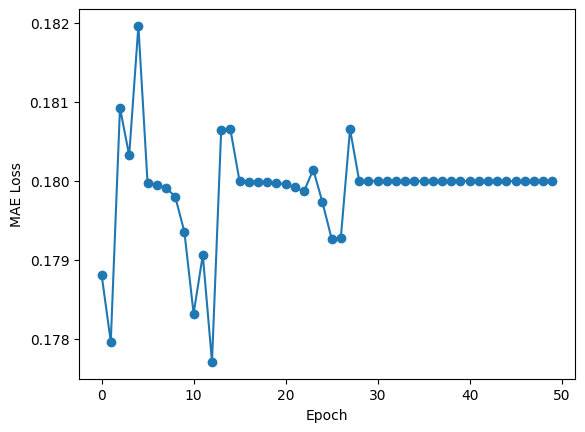

(                 0         1         2         3         4         5  \
 pixel0    0.010810 -0.002432 -0.002299 -0.001341 -0.001472  0.009401   
 pixel1    0.002141  0.004367 -0.006007 -0.000127 -0.011714  0.007155   
 pixel2   -0.018482 -0.003971 -0.000258 -0.018673  0.016567 -0.013729   
 pixel3    0.006640 -0.016909 -0.005945  0.014790 -0.000748  0.010802   
 pixel4    0.001161 -0.002662 -0.006541  0.010412  0.000229 -0.004209   
 ...            ...       ...       ...       ...       ...       ...   
 pixel779  0.007549  0.009066  0.009320 -0.010104 -0.014365 -0.016896   
 pixel780  0.008524 -0.006723  0.009792 -0.002332 -0.000532 -0.003268   
 pixel781  0.000280  0.011370  0.003455 -0.019096  0.018959  0.020583   
 pixel782  0.000963  0.001932  0.007198  0.012888 -0.012104  0.014381   
 pixel783  0.008507 -0.007718  0.001162 -0.012227 -0.004127 -0.020405   
 
                  6         7         8         9  
 pixel0    0.012846  0.008543 -0.000167  0.011125  
 pixel1    0.00336

In [11]:
train(X, one_hot, W1, b1, W2, b2, 50, 0.001)